In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

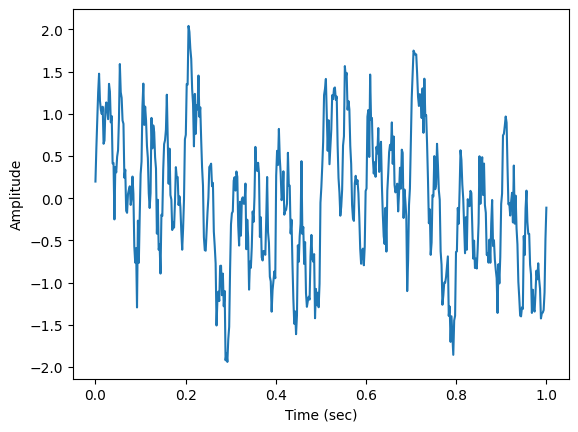

In [4]:
# Create EEG data
sampling_rate = 500  # Hz
t = np.linspace(0, 1, sampling_rate)

# Simulate different brain wave frequencies
delta_wave = 0.5 * np.sin(2 * np.pi * 2 * t)  # 2 Hz
theta_wave = 0.5 * np.sin(2 * np.pi * 6 * t)  # 6 Hz
alpha_wave = 0.5 * np.sin(2 * np.pi * 10 * t)  # 10 Hz
beta_wave = 0.5 * np.sin(2 * np.pi * 20 * t)  # 20 Hz
gamma_wave = 0.5 * np.sin(2 * np.pi * 40 * t)  # 40 Hz

# Combine the waves for EEG
eeg_signal = delta_wave + theta_wave + alpha_wave + beta_wave + gamma_wave
noise = np.random.normal(0, 0.2, sampling_rate)
eeg_signal_noisy = eeg_signal + noise

# plot
fig, ax = plt.subplots()
ax.plot(t, eeg_signal_noisy)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Amplitude")
plt.show()



In [5]:
# Data Preparation for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        y.append(dataset[i + time_step])
    return np.array(X), np.array(y)

# Reshape
time_step = 10   # number of previous time steps to consider
X, y = create_dataset(eeg_signal_noisy, time_step)

# Reshape the data to be [samples, time steps, features] as expected by LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"Shape of X: {X.shape}, shape of y: {y.shape}")


Shape of X: (489, 10, 1), shape of y: (489,)


In [6]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [8]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=50, batch_first=True)  # No return_sequences
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)  # No return_sequences
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)  # Output shape: (batch_size, seq_len, hidden_size)
        x, _ = self.lstm2(x)  # Output shape: (batch_size, seq_len, hidden_size)
        x = x[:, -1, :]  # Mimic return_sequences=False by taking the last time step
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train the model
epochs = 20
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


Epoch 1/20, Loss: 0.6356209516525269
Epoch 2/20, Loss: 0.22885173559188843
Epoch 3/20, Loss: 0.35242658853530884
Epoch 4/20, Loss: 0.44929784536361694
Epoch 5/20, Loss: 0.07189944386482239
Epoch 6/20, Loss: 0.18208712339401245
Epoch 7/20, Loss: 0.10625581443309784
Epoch 8/20, Loss: 0.189408078789711
Epoch 9/20, Loss: 0.16566716134548187
Epoch 10/20, Loss: 0.06604210287332535
Epoch 11/20, Loss: 0.058151621371507645
Epoch 12/20, Loss: 0.08657603710889816
Epoch 13/20, Loss: 0.11840786039829254
Epoch 14/20, Loss: 0.09488236904144287
Epoch 15/20, Loss: 0.13112212717533112
Epoch 16/20, Loss: 0.1856783777475357
Epoch 17/20, Loss: 0.07591521739959717
Epoch 18/20, Loss: 0.1797345131635666
Epoch 19/20, Loss: 0.09476135671138763
Epoch 20/20, Loss: 0.07086953520774841


In [10]:
# Predict
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).squeeze().numpy()


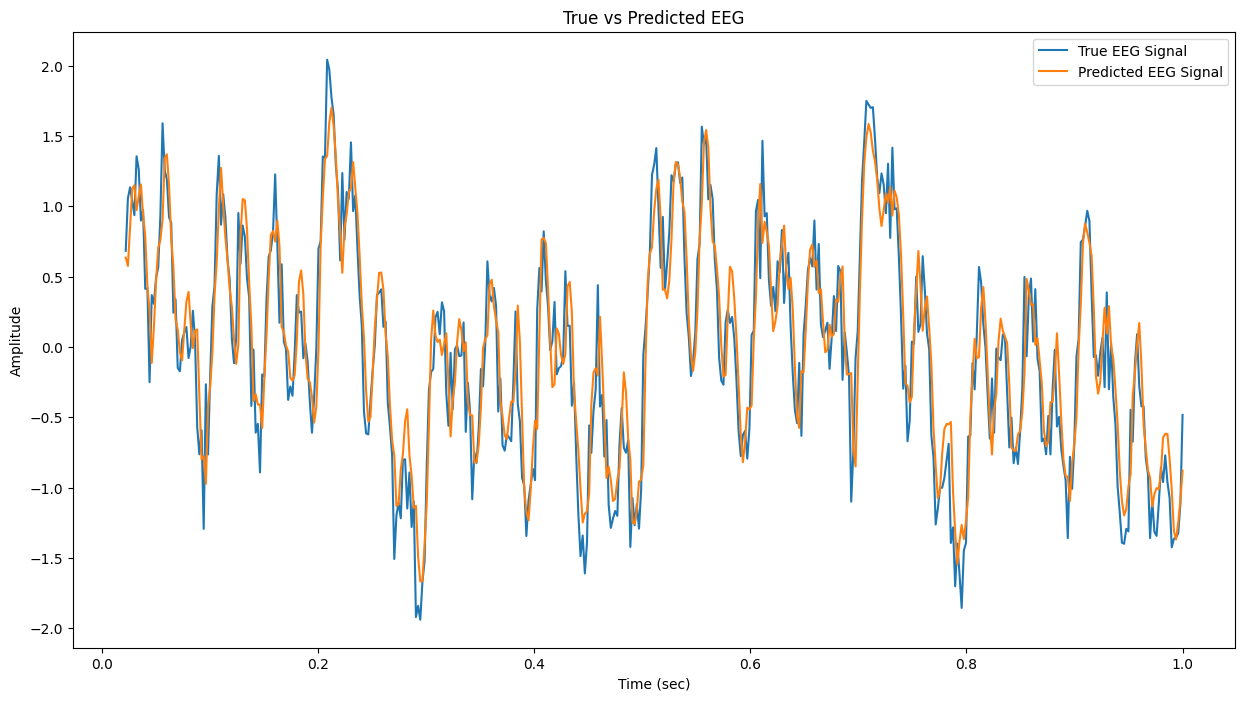

In [11]:
# Plot True vs Predicted EEG signals
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(t[time_step+1:], y, label="True EEG Signal")
ax.plot(t[time_step+1:], predictions, label="Predicted EEG Signal")
ax.set_title("True vs Predicted EEG")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()
